In [11]:
from __future__ import annotations

from pathlib import Path
from typing import Any, Callable

import ddpm_model
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm, trange


In [12]:
# try:
#     import os

#     from google.colab import drive

#     drive.mount("/content/drive")
#     os.chdir("/content/drive/MyDrive/Colab Notebooks")
# except ImportError:
#     print("Running locally.")

# assert Path("ddpm_models").exists(), "Couldn't find model folder"


In [13]:
def train(
    train_model: nn.Module,
    train_optimizer: torch.optim.Optimizer,
    train_scheduler: torch.optim.lr_scheduler.LRScheduler,
    train_dataloader: torch.utils.data.DataLoader[tuple[torch.Tensor, Any]],
    train_epochs: int,
    train_device: torch.device,
    ema: bool = True,
    per_epoch_callback: Callable = None,
    double_bar: bool = False,
    extra_desc: str = None,
):
    """
    Training loop

    Parameters
    ----------
    train_model: nn.Module
        Pytorch model
    train_optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    train_scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    train_dataloader: utils.DataLoader
        Pytorch dataloader
    train_epochs: int
        Number of epochs to train
    train_device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    double_bar: bool
        Whether to add a progress bar within an epoch
    extra_desc: str
        Extra progress bar description
    """

    # Setup progress bar

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = train_dataloader.batch_size * ema_steps / train_epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ddpm_model.ExponentialMovingAverage(
            train_model, avg_device=train_device, decay=1.0 - ema_alpha
        )

    full_bar = trange(
        train_epochs,
        desc="Training" if not extra_desc else f"Training ({extra_desc})",
        smoothing=0.05,
        unit="epoch",
        position=1,
    )
    for epoch in full_bar:
        # Switch to train mode
        train_model.train()

        epoch_bar = tqdm(
            train_dataloader,
            leave=False,
            position=2,
            desc=f"Epoch {epoch}",
            disable=not double_bar,
        )
        for x, _label in epoch_bar:
            x = x.to(train_device)
            train_optimizer.zero_grad()
            loss = train_model.loss(x)
            loss.backward()
            train_optimizer.step()
            train_scheduler.step()

            # Update progress bar
            epoch_bar.set_postfix(
                loss=f"⠀{loss.item():12.4f}",
                lr=f"{train_scheduler.get_last_lr()[0]:.2E}",
                refresh=False,
            )

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter % ema_steps == 0:
                    ema_model.update_parameters(train_model)

        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else train_model)


In [14]:
# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256
# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(
            lambda x: x + torch.rand(x.shape) / 255
        ),  # Dequantize pixel values
        transforms.Lambda(lambda x: (x - 0.5) * 2.0),  # Map from [0,1] -> [-1, -1]
        transforms.Lambda(lambda x: x.flatten()),
    ]
)

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST("./mnist_data", download=True, train=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)
# Select device
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.mps.is_available():
    device = "mps:0"
else:
    device = "cpu"

print(f"Running on {device}")


Running on mps:0


Training (target=x):   0%|          | 0/100 [00:00<?, ?epoch/s]

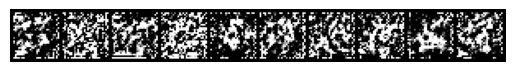

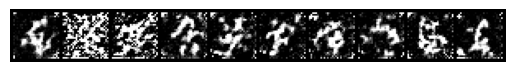

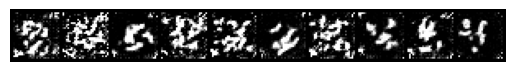

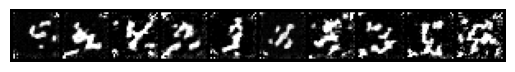

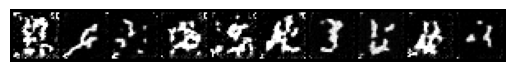

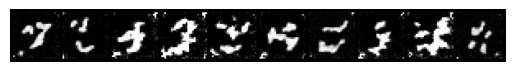

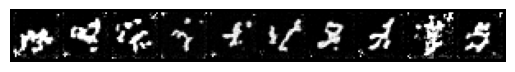

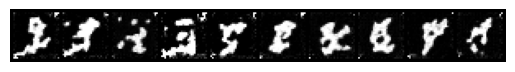

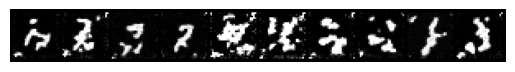

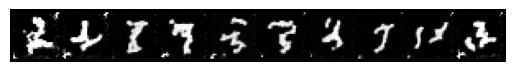

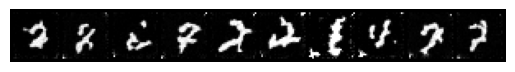

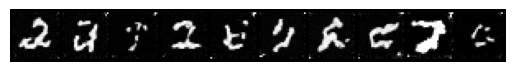

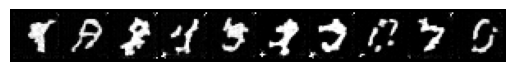

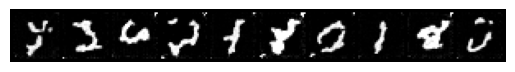

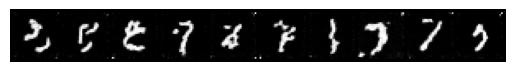

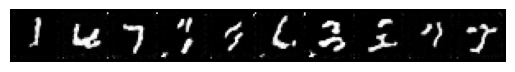

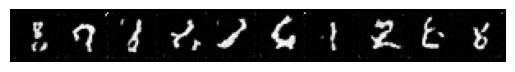

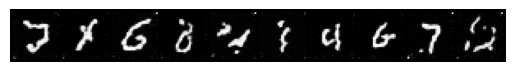

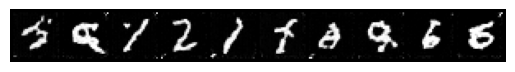

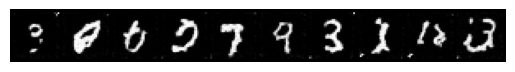

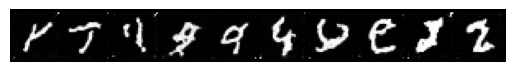

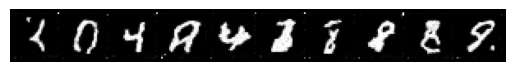

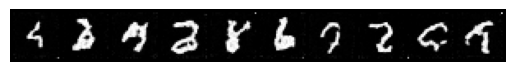

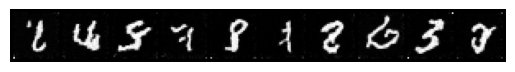

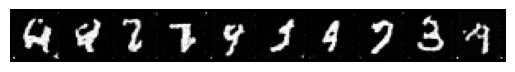

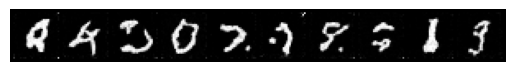

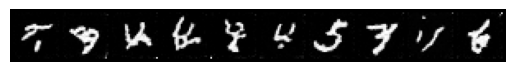

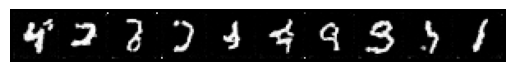

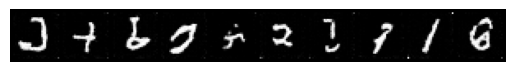

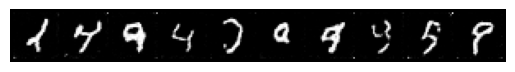

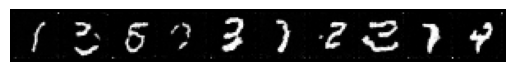

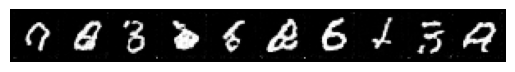

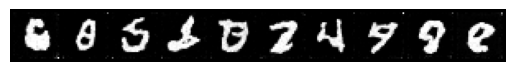

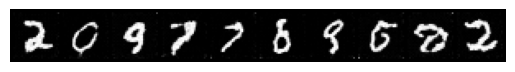

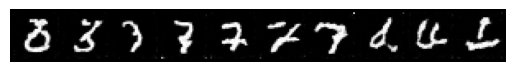

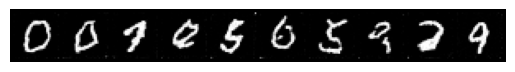

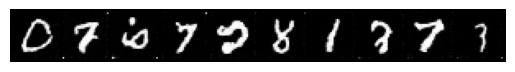

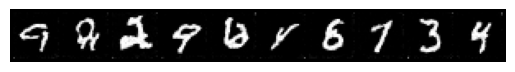

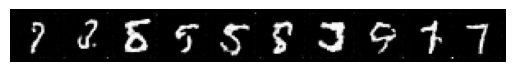

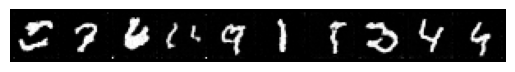

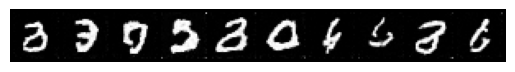

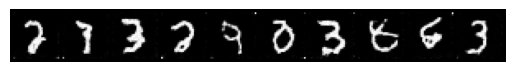

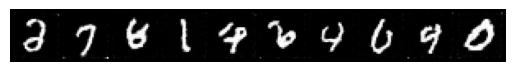

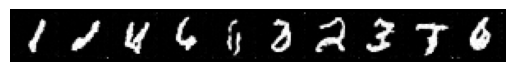

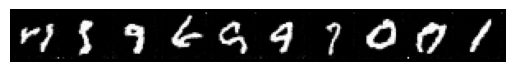

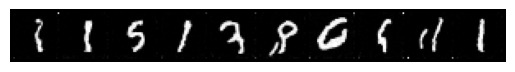

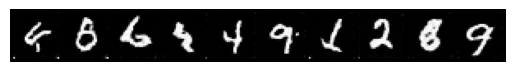

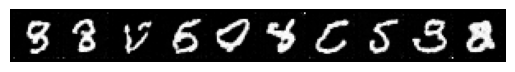

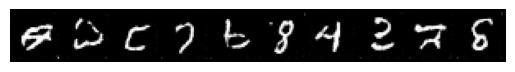

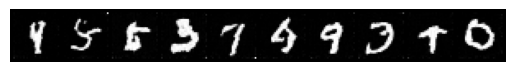

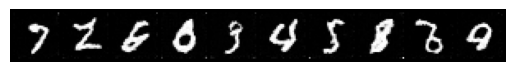

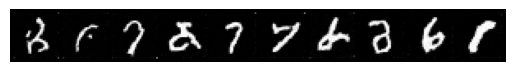

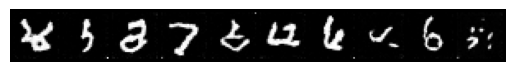

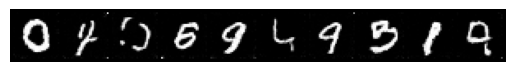

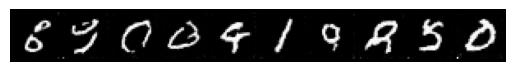

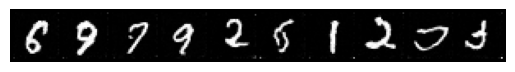

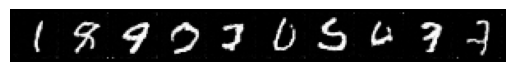

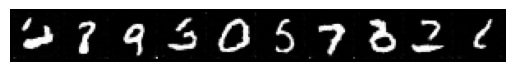

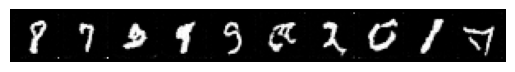

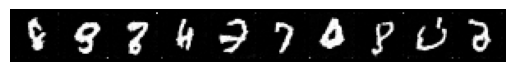

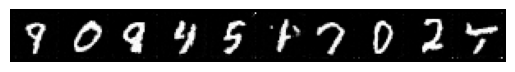

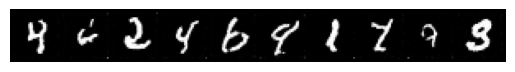

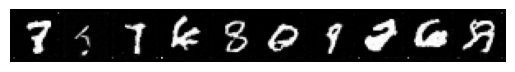

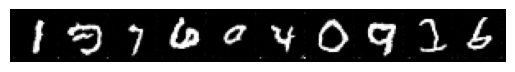

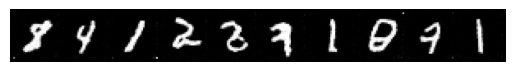

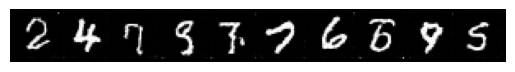

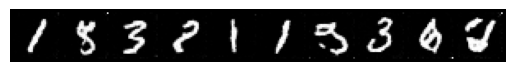

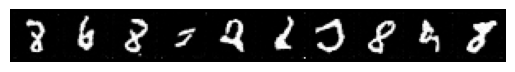

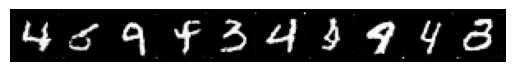

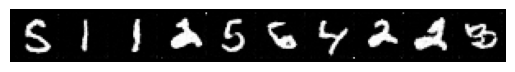

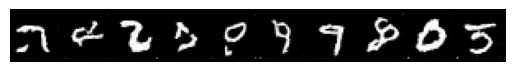

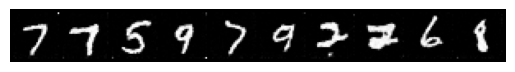

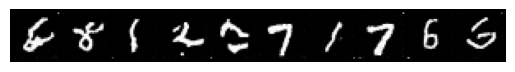

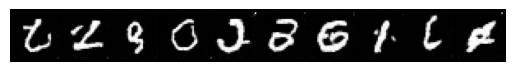

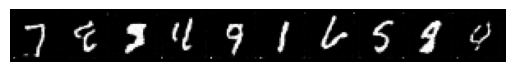

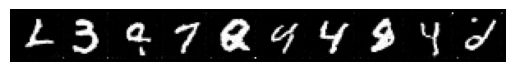

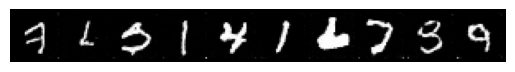

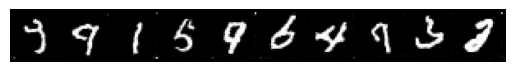

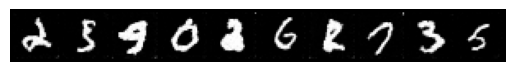

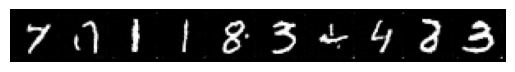

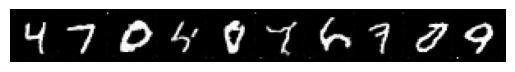

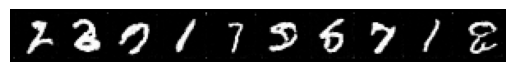

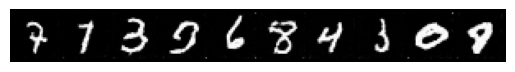

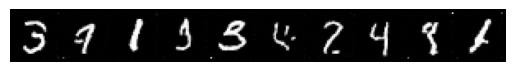

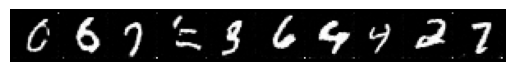

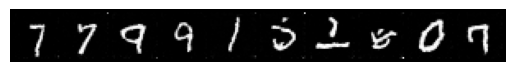

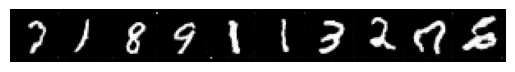

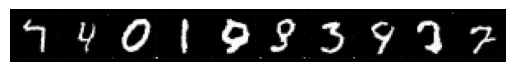

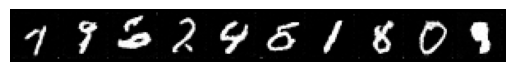

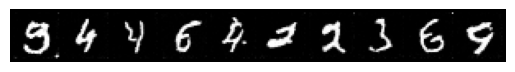

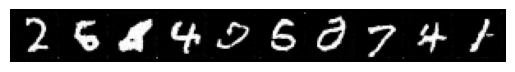

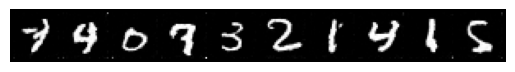

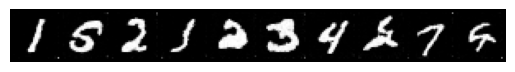

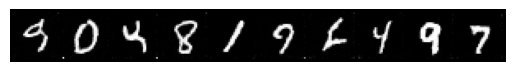

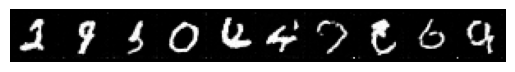

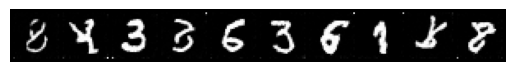

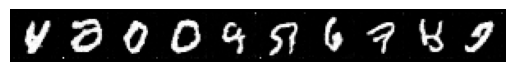

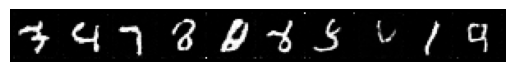

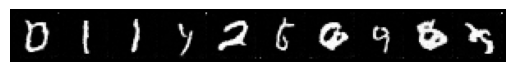

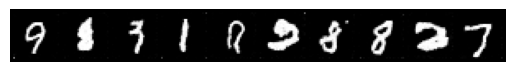

Training (target=0):   0%|          | 0/100 [00:00<?, ?epoch/s]

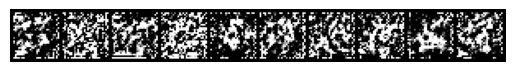

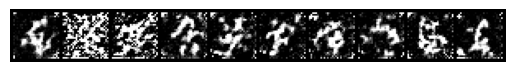

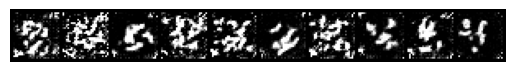

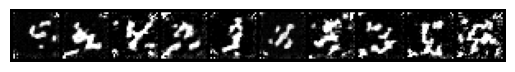

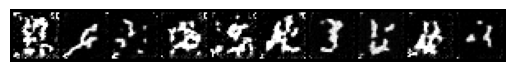

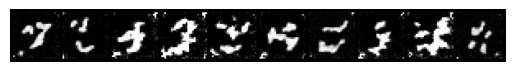

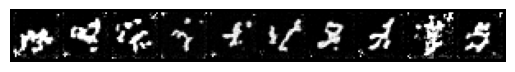

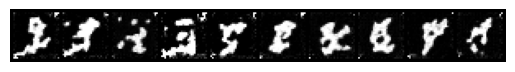

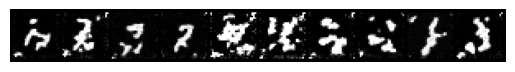

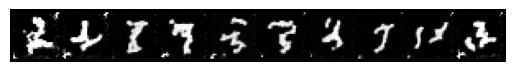

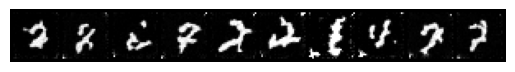

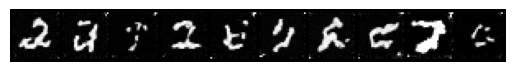

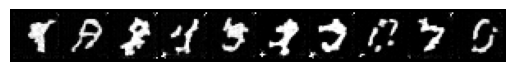

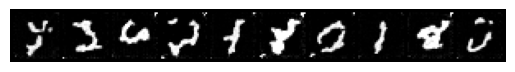

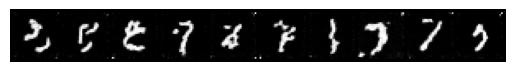

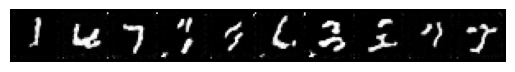

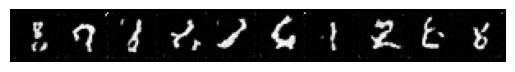

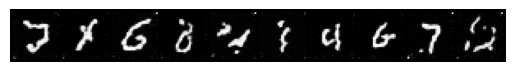

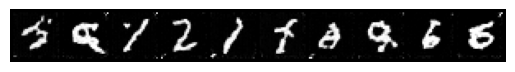

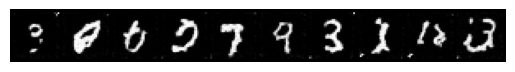

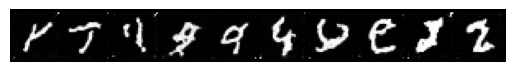

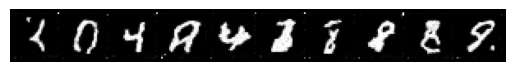

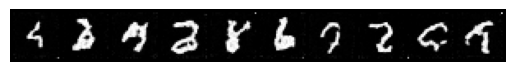

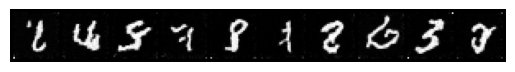

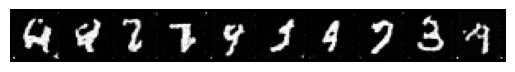

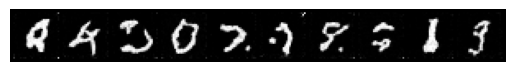

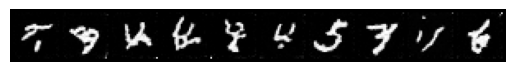

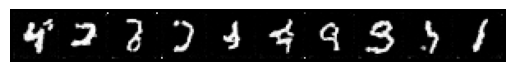

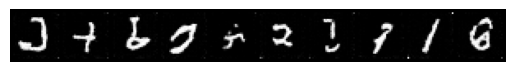

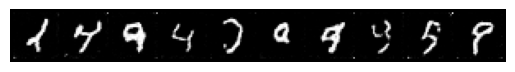

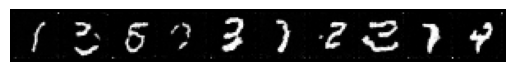

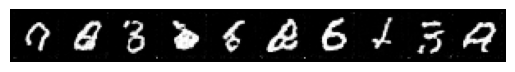

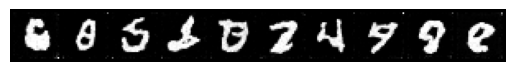

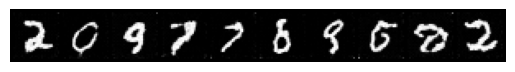

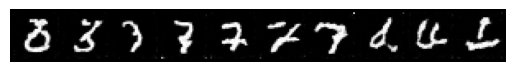

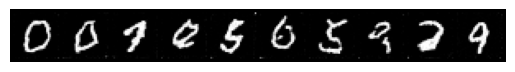

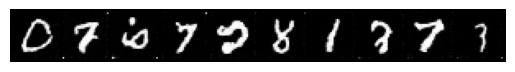

KeyboardInterrupt: 

In [15]:
def reporter(train_model: nn.Module):
    """Callback function used for plotting images during training"""

    # Switch to eval mode
    train_model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = train_model.sample((nsamples, 28 * 28)).cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples + 1) / 2
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()


# Base models, three different ways to predict the mean
# for tgt in ("e", "u", "x0"):
for tgt in "x0":
    if Path(f"ddpm_models/base_{tgt}.pt").exists():
        print(f"Skipping target {tgt}, already exists")
        continue

    torch.manual_seed(0)

    # Construct Unet
    # The original ScoreNet expects a function with std for all the
    # different noise levels, such that the output can be rescaled.
    # Since we are predicting the noise (rather than the score), we
    # ignore this rescaling and just set std=1 for all t.
    mnist_unet = ddpm_model.ScoreNet(None)

    # Construct model
    #  model = ddpm_model.DDPM(mnist_unet, max_t=T, predict_mean_by=tgt).to(device)
    model = ddpm_model.DDPM(mnist_unet, max_t=T).to(device)
    model.compile(fullgraph=True)

    # Construct optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Setup simple scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

    # Call training loop
    train(
        model,
        optimizer,
        scheduler,
        dataloader_train,
        train_epochs=epochs,
        train_device=device,
        ema=True,
        per_epoch_callback=reporter,
        extra_desc=f"target={tgt}",
    )

    torch.save(model, f"./models/base_{tgt}.pt")


In [ ]:
# Noise predictor model, three different ways to reduce the variance
for mthd in ("low-discrepency", "importance-sampling", "importance-batch"):
    if Path(f"ddpm_models/variance_{mthd}.pt").exists():
        print(f"Skipping method {mthd}, already exists")
        continue

    torch.manual_seed(0)

    mnist_unet = ddpm_model.ScoreNet(None)
    model = ddpm_model.DDPM(mnist_unet, max_t=T, reduce_variance_by=mthd).to(device)
    model.compile(fullgraph=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

    train(
        model,
        optimizer,
        scheduler,
        dataloader_train,
        train_epochs=epochs,
        train_device=device,
        ema=True,
        per_epoch_callback=reporter,
        extra_desc=f"method={mthd}",
    )

    torch.save(model, f"ddpm_models/variance_{mthd}.pt")
